# YOUR NAME HERE: Zachary Hull

# A5 Convolutional Neural Network (Total 150pts)


## 1. Import libraries (Total 6pts)

### 1.1 Import torch, torchvision, torchvision.transforms, torch.utils.data and torch.nn (6pts)

In [1]:
# TODO
import torch, torchvision, torchvision.transforms, torch.utils.data, torch.nn

## 2. Data Preparation (Total 32pts)


### 2.1 Image Transformation (12pts)
Define a transformation pipeline using torchvision.transforms.Compose.

In the pipeline, use **ColorJitter, GaussianBlur, RandomHorizontalFlip, ToTensor and Normalize** from the transforms library.

For the first four transformations, use suitable parameters of your informed choice. At the end, normalize the images with mean 0.5 and variance 0.5.

Read about these transformations here: https://pytorch.org/vision/0.9/transforms.html

In [2]:
# TODO
transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), 
    torchvision.transforms.GaussianBlur(kernel_size=3),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### 2.2 Prepare train and test set by loading CIFAR10 dataset from torchvision.datasets. (4pts)
Make sure you are using the **transform** pipeline (you just wrote in task #2.1) on both train and test set. 

**Hint:** Preparing train and test sets can be directly achieved by utilizing the class parameters.


Read about CIFAR10 dataset class in PyTorch: https://pytorch.org/vision/0.9/datasets.html#cifar

In [3]:
# TODO
training = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 77199841.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.3 Use torch.utils.data.random_split() to make a validation set from the training set with 80:20 split. (3pts)

Make sure the training set you'll use after this point excludes the validation set of images 


In [4]:
# TODO
training_size = int(0.8 * len(training))
validation_size = len(training) - training_size
train, validation = torch.utils.data.random_split(training, [training_size, validation_size])

### 2.4 Prepare three dataloaders for train, validation and test set. Use an appropriate batchsize of your choice. (1+2+2+2 =7pts)


**Hints:**
1. Remember that choosing a batchsize is always a trade-off between efficiency and generalizability. With large batchsize, your model learns more and better in each forward pass, but each pass will require larger computation. On the other hand, with small batchsize, it might converge quicker, but each forward pass teaches features from a smaller subset, which may not be a good representation of the overall data; leading to jittery convergence.
2. During training, you will use the train and validation set for tracking the loss and avoiding overfitting. The test set will be hold out until you are ready to evaluate a trained model on new data. 

Read about pytorch Dataloaders here:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [5]:
# TODO: set a batch size
from torch.utils.data import DataLoader
batch = 64

# TODO: write dataloader for train set
train_dataloader = DataLoader(training, batch, shuffle=True)

# TODO: write dataloader for test set
test_dataloader = DataLoader(test, batch, shuffle=True)

# TODO: write dataloader for validation set
validation_dataloader = DataLoader(validation, batch, shuffle=True)


### 2.5 Load a random batch of images from the training set using the trainloader. Then use *make_grid()*  from *torchvision.utils* and *imshow()* from *matplotlib.pyplot* to show the images. Also, print the corresponding true labels for those image samples. (6pts)
Hint: you may need to reshape the *make_grid()* output to comply with the format *imshow()* accepts.

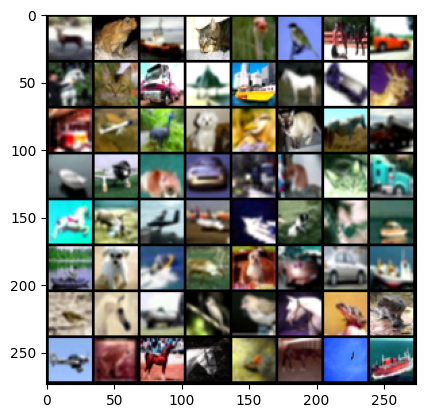

tensor([4, 6, 8, 3, 2, 2, 7, 1, 7, 3, 9, 0, 8, 7, 9, 4, 9, 0, 2, 5, 2, 3, 7, 9,
        8, 0, 5, 1, 9, 3, 3, 9, 7, 4, 0, 0, 8, 5, 3, 8, 8, 5, 8, 4, 5, 1, 1, 8,
        2, 7, 9, 2, 2, 7, 6, 3, 0, 6, 7, 7, 2, 7, 2, 8])


In [6]:
# TODO: load a random batch of test set images
import torchvision.utils as vis
load_image = iter(train_dataloader)
images, labels = next(load_image)

# TODO: show the images
grid = vis.make_grid(images, normalize=True, scale_each=True)
import matplotlib.pyplot as plt
plt.imshow(grid.permute(1,2,0))
plt.show()

# TODO: print the ground truth class labels for these images
print(labels)


## 3. Model Design (Total 22pts)

### 3.1 Define a neural network model: (2+7+7 =16pts)
- Name the model class with your first name
- In the following sequential order, the model should consist:

    (1) a 2D convolution layer with 6 filters, dimension of each filter is (5, 5), stride=1, no zero padding
    
    (2) a Max Pool layer with filter size (2, 2), stride=2
    
    (3) a 2D convolution layer with 16 filters, dimension of each filter is (5, 5), stride=1, no zero padding

    (4) a 2D Max Pool layer with filter size (2, 2), stride=2
    
    ~ a flatten layer ~

    (5) a Dense/Fully-connected layer with 120 neurons
    
    ~ a ReLU activation ~
    
    ~ a Dropout Layer ~

    (6) a Dense/Fully-connected layer with 80 neurons
    
    ~ a ReLU activation ~

    (7) a Dense/Fully-connected layer with 10 neurons

Note: 
1. Flatten, ReLU and Dropout are not really "layers". They are operations with specific purpose. But in model construction in pytorch, they are abstracted as layers.
    
    Flatten is used to convert the 4th layer output to a 1D tensor so that it can be passed through the next fully-connected layer. Since each forward pass takes a batch of data, use the *start_dim* parameter of *torch.flatten()* appropriately to keep the batch dimension intact.
    
    ReLU is an activation that transforms the Dense Layer's linear output to a non-linear "active" output.
    
    Dropout is a regularization technique. Read more in slides. In this assignment, you can drop neurons with 50% probability. 

2. This dataset has 10 classes, hence the final layer consists 10 neurons. 

3. The model architecture is similar to the one you saw in in-class Quiz 2, with an extra dense layer in the end. 

    Read about building your custom model in pytorch here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

    The official pytorch documentation on conv, flatten, rely, dense are also resourceful.


In [10]:
import torch.nn as nn
import torch.functional as F
class Zachary(nn.Module):
    def __init__(self):
        # TODO: Initialize the layers
        super(Zachary, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)




    def forward(self, x):
        # TODO: Define the dataflow through the layers
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3.2 Create an instance of the model class that you just prepared. (2pts)

In [8]:
# TODO:
model = Zachary()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.3 Set up Cross Entropy Loss as the loss function and *Adam* as the optimizer. Use a learning rate of your choice for the optimizer. (4pts) 


In [9]:
# TODO: Define the loss function and optimizer
import torch.optim as optim
cel = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 4. Training and Validation (Total 50pts)


### 4.1 Write a training loop to load data, compute model output, compute loss and backpropagating it to update model parameters. (30pts)

The # TODO tags below contain further instructions. 

In [13]:
# TODO: Define number of epochs
epoch = 20

# TODO: Initialize empty lists to store training loss, training accuracy, validation loss, validation accuracy 
# You will use these lists to plot the loss history.
t_loss_history = []
t_accuracy_history = []
v_loss_history = []
v_accuracy_history = []
t_loss = []
t_accuracy =[]
v_loss = []
v_accuracy = []



# TODO: Loop through the number of epochs
for i in range(epoch):

    # TODO: set model to train mode
    model.train()

    # TODO: iterate over the training data in batches
    for j, (inputs, labels) in enumerate(train_dataloader):
        
        # TODO: get the image inputs and labels from current batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        # TODO: set the optimizer gradients to zero to avoid accumulation of gradients
        optimizer.zero_grad()

        # TODO: compute the output of the model
        output = model(inputs)

        # TODO: compute the loss on current batch
        loss = cel(output, labels)
        
        # TODO: backpropagate the loss
        loss.backward()

        # TODO: update the optimizer parameters
        optimizer.step()

        # TODO: update the train loss and accuracy
        t_loss_history.append(loss.item())
        _, predict = torch.max(output, 1)
        t_accuracy_history.append((predict == labels).sum().item() / labels.size(0))

    # TODO: compute the average training loss and accuracy and store in respective arrays
    t_loss.append(sum(t_loss_history[-len(train_dataloader):]) / len(train_dataloader))
    t_accuracy.append(sum(t_accuracy_history[-len(train_dataloader):]) / len(train_dataloader))

    # TODO: set the model to evaluation mode
    model.eval()

    # TODO: keeping the gradient computation turned off, loop over batches of data from validation set.
    with torch.no_grad():
      for inputs, labels in validation_dataloader:
    
            # TODO: compute output of the model
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)

            # TODO: compute the loss
            loss = cel(output, labels)
            
            # TODO: compute the validation loss and accuracy
            v_loss_history.append(loss.item())
            _, predict = torch.max(output.data, 1)
            v_accuracy_history.append((predict==labels).sum().item() / labels.size(0))

    # TODO: compute the average validation loss and accuracy and store in respective lists
    v_loss.append(sum(v_loss_history[-len(validation_dataloader):]) / len(validation_dataloader))
    v_accuracy.append(sum(v_accuracy_history[-len(validation_dataloader):]) / len(validation_dataloader))

    # TODO: print the training loss, training accuracy, validation loss and validation accuracy at the end of each epoch
    print(f'Epoch [{i+1}/{epoch}], Train Loss: {t_loss[i]:.4f}, Train Acc: {t_accuracy[i]:.4f}, Val Loss: {v_loss[i]:.4f}, Val Acc: {v_accuracy[i]:.4f}')


    # TODO: save the model parameters once in every 5 epochs
    if (i+1) % 5 == 0:
      torch.save(model.state_dict(), f'cifar10_model_epoch_{i+1}.pth')
    

Epoch [1/20], Train Loss: 1.5364, Train Acc: 0.4460, Val Loss: 1.4110, Val Acc: 0.4963
Epoch [2/20], Train Loss: 1.4932, Train Acc: 0.4632, Val Loss: 1.3881, Val Acc: 0.5025
Epoch [3/20], Train Loss: 1.4577, Train Acc: 0.4749, Val Loss: 1.3412, Val Acc: 0.5264
Epoch [4/20], Train Loss: 1.4358, Train Acc: 0.4861, Val Loss: 1.3268, Val Acc: 0.5254
Epoch [5/20], Train Loss: 1.4188, Train Acc: 0.4924, Val Loss: 1.3103, Val Acc: 0.5316
Epoch [6/20], Train Loss: 1.4004, Train Acc: 0.4975, Val Loss: 1.3147, Val Acc: 0.5404
Epoch [7/20], Train Loss: 1.3834, Train Acc: 0.5057, Val Loss: 1.2748, Val Acc: 0.5494
Epoch [8/20], Train Loss: 1.3707, Train Acc: 0.5103, Val Loss: 1.2869, Val Acc: 0.5412
Epoch [9/20], Train Loss: 1.3559, Train Acc: 0.5161, Val Loss: 1.2520, Val Acc: 0.5606
Epoch [10/20], Train Loss: 1.3487, Train Acc: 0.5183, Val Loss: 1.2542, Val Acc: 0.5619
Epoch [11/20], Train Loss: 1.3392, Train Acc: 0.5239, Val Loss: 1.2328, Val Acc: 0.5658
Epoch [12/20], Train Loss: 1.3316, Train 

### 4.2 Plot and compare (5+5 =10pts)
1. training and validation loss over the number of epochs
2. training and validation accuracy over the number of epochs

(Hint: Use plot() from *matplotlib.pyplot*, import it if you haven't already done so.)

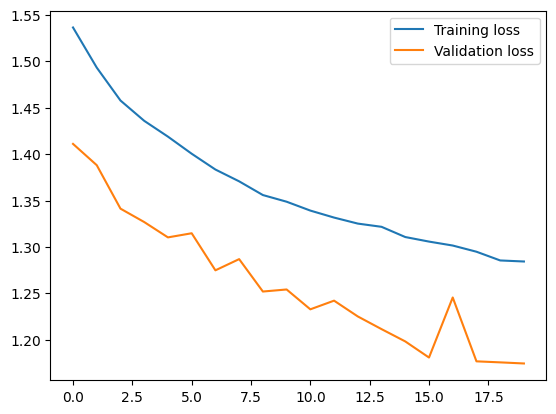

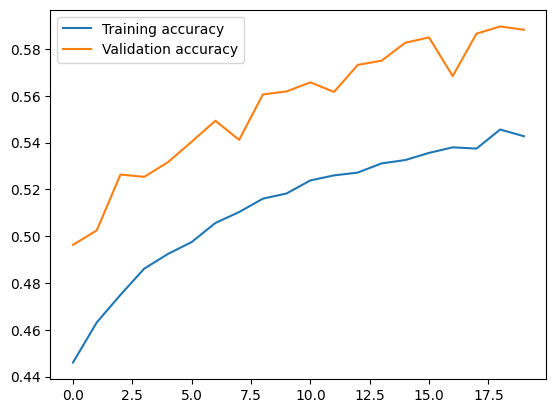

In [14]:
# TODO: plot the training and validation loss
plt.plot(t_loss, label="Training loss")
plt.plot(v_loss, label="Validation loss")
plt.legend()
plt.show()

# TODO: plot the training and validation accuracy
plt.plot(t_accuracy, label="Training accuracy")
plt.plot(v_accuracy, label="Validation accuracy")
plt.legend()
plt.show()



### 4.3 Discussion: (2*5 = 10pts)
(1) Does the training loss and accuracy improve as number of epoch increases?

(2) Does the validation loss and accuracy improve as number of epoch increases?

(3) Are there any sign of overfitting in the results? If so, when did it start to occur?

(4) How many epochs did it take for the model to converge to a good solution?

(5) What enhancement can be tried to the architecture to further improve the validation performance?

~ # TODO
1.) The training accuracy improves as the number of epoch increases
2.) The validation accuracy improves as the number of epoch increases
3.) There are some signs of overfitting at 15 epochs, but it is not consistantly heading in different directions
4.) It took about 18 epochs to converge to a good solution
5.) Improvements that could be made would be using normalization

## 5. Testing on new data (Total 40pts)


### 5.1 Load the best performing model (one with good validation accuracy and without overfitting) among the ones you saved. (4pts)

In [22]:
# TODO: instantiate a model
model2 = Zachary()

# TODO: load parameters from one of the saved model states
model2.load_state_dict(torch.load(f'cifar10_model_epoch_{15}.pth'))

# TODO: set this model to evaluation mode 
model2.eval()


Zachary(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

### 5.2 Take a random batch of images from test set and show the images. Print the corresponding ground truth class labels. Then compute model output (model selected at previous step) and the predicted labels for the images in this batch. (10pts)

This is similar to task #2.5 with additional task on computing model output and printing predicted labels.

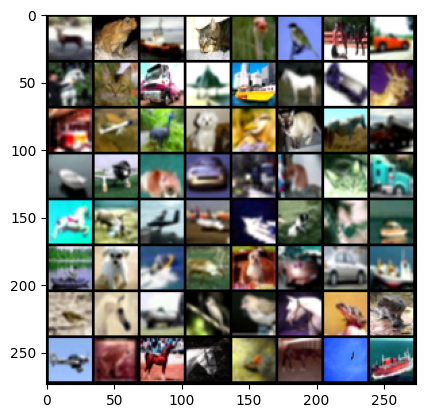

labels: tensor([6, 6, 6, 8, 6, 7, 7, 0, 5, 6, 3, 2, 4, 6, 9, 9, 4, 3, 7, 9, 8, 8, 9, 5,
        0, 6, 6, 3, 8, 7, 4, 4, 2, 6, 5, 6, 5, 0, 0, 4, 4, 2, 5, 9, 2, 6, 8, 7,
        5, 0, 0, 5, 6, 3, 7, 5, 1, 5, 6, 2, 4, 5, 5, 2])
prediction: tensor([9, 6, 6, 8, 6, 7, 0, 0, 8, 6, 3, 5, 4, 6, 9, 8, 3, 8, 4, 9, 8, 8, 9, 5,
        0, 3, 3, 5, 8, 7, 4, 4, 3, 3, 5, 5, 5, 0, 9, 6, 2, 2, 6, 9, 8, 6, 8, 7,
        5, 8, 3, 2, 1, 3, 7, 7, 6, 5, 6, 3, 2, 5, 3, 2])


In [30]:
# TODO: load a random batch of test set images
load2 = iter(test_dataloader)
images2, labels2 = next(load2)

# TODO: show the images
grid2 = vis.make_grid(images2, normalize=True, scale_each=True)
plt.imshow(grid.permute(1,2,0))
plt.show()

# TODO: print the ground truth class labels for these images
print("labels: " + str(labels2))

# TODO: compute model output
output = model2(images2)

# TODO: print the predicted class labels for these images
_, pred = torch.max(output.data, 1)
print("prediction: " + str(pred))

### 5.3 Compute the average accuracy on test data using this model. (4+2 =6pts)
Loop over the test set, compute accuracy on each batch, lastly print the average accuracy. 

In [33]:
# TODO: compute accuracy on each batch of test set
correct = 0
total = 0
for images2, labels2 in test_dataloader:
  output = model2(images2)
  _, pred = torch.max(output.data, 1)
  correct += (pred == labels2).sum().item()
  total += labels2.size(0)

accuracy = 100 * correct / total

# TODO: print the average accuracy
print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 55.23%


### 5.4 Compute the average accuracy for each individual class. (8+4 =12pts)
Hint: similar to #5.3. During each loop, log the accuracy for each class separately (a python/numpy dictionary can help). Then print the individual accuracy for the 10 output classes. 

In [44]:
# TODO: compute per-class accuracy on each batch of test set
classes = [k for k, v in test.class_to_idx.items()]
correct = 0
total = 0
for images2, labels2 in test_dataloader:
  output = model2(images2)
  _, pred = torch.max(output.data, 1)
  correct += (pred == labels2).sum().item()
  total += labels2.size(0)

  accuracy = 100 * correct / total
  print("Accuracy for loop: {:.2f}%".format(accuracy))


# TODO: print per-class accuracy for 10 output classes
correct_per_class = list(0 for i in range(10))
total_per_class = list(0 for i in range(10))

with torch.no_grad():
  for images2, labels2 in test_dataloader:
    images2 = images2.to(device)
    labels2 = labels2.to(device)

    output = model2(images2)
    _, pred = torch.max(output.data, 1)

    for i in range(labels2.size(0)):
      lab = labels2[i]
      predict = pred[i]
      if (lab == predict):
        correct_per_class[lab] += 1
      total_per_class[lab] += 1
per_class_accuracy = []
for i in range(10):
  accuracy = 100 * correct_per_class[i] / total_per_class[i]
  per_class_accuracy.append(accuracy)
  print("Accuracy of %5s : %2d %%" % (classes[i], accuracy))



Accuracy for loop: 62.50%
Accuracy for loop: 59.38%
Accuracy for loop: 56.77%
Accuracy for loop: 56.25%
Accuracy for loop: 55.00%
Accuracy for loop: 54.95%
Accuracy for loop: 55.36%
Accuracy for loop: 54.88%
Accuracy for loop: 54.51%
Accuracy for loop: 55.16%
Accuracy for loop: 54.97%
Accuracy for loop: 55.21%
Accuracy for loop: 55.89%
Accuracy for loop: 56.03%
Accuracy for loop: 56.04%
Accuracy for loop: 56.05%
Accuracy for loop: 56.25%
Accuracy for loop: 56.25%
Accuracy for loop: 55.67%
Accuracy for loop: 55.55%
Accuracy for loop: 55.58%
Accuracy for loop: 55.47%
Accuracy for loop: 55.64%
Accuracy for loop: 55.47%
Accuracy for loop: 55.38%
Accuracy for loop: 55.65%
Accuracy for loop: 55.90%
Accuracy for loop: 55.75%
Accuracy for loop: 55.60%
Accuracy for loop: 55.73%
Accuracy for loop: 55.75%
Accuracy for loop: 55.66%
Accuracy for loop: 55.73%
Accuracy for loop: 55.88%
Accuracy for loop: 55.71%
Accuracy for loop: 55.73%
Accuracy for loop: 55.70%
Accuracy for loop: 55.80%
Accuracy for

### 5.5 Discussion: (2+2+4 =8pts)
1. Which class of images were detected with highest accuracy? 
2. Which class of images were hardest for the model to detect? 
3. Explain 1-2 possible reasons why detection of some class can be harder for the same model. 

~ # TODO
1.) The class of images that were detected with the highest accuracy was the ships
2.) The class of images that was the hardest to detect was the cats.
3.) A possible reason that some classes were harder to detect would be the appearence. It may be harder for the modelto detect images with more variance, such as cats